In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

repo = git.Repo('.', search_parent_directories=True)
created_data_path = f'{repo.working_tree_dir}/insectrec/created_data'
path_impy_crops_export = f'{created_data_path}/impy_crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

if not os.path.isdir(path_images_augmented):
    os.mkdir(path)
    
clean = True 
if clean:
    os.system(f'rm -rf {path_images_augmented}*')

epochs = 100
batch_size = 32
monitor='val_loss'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = 'platebased_XCEPT_six'

In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_orig = pd.DataFrame()
df_orig['x'] = pd.Series(glob.glob(f"{path_impy_crops_export}/*/*.jpg"))
df_orig['pname'] = df_orig['x'].apply(lambda p: '_'.join(p.split('/')[-1].split('.')[-2].split('_')[:-8]))
df_orig['y_text'] = df_orig['x'].apply(lambda x: x.split('/')[-2])
df_orig['y'] = le.fit_transform(df_orig.y_text)

nr of test plates: 24
nr of all plates: 262


/home/kalfasyan/anaconda3/envs/objdetecet/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetecet/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


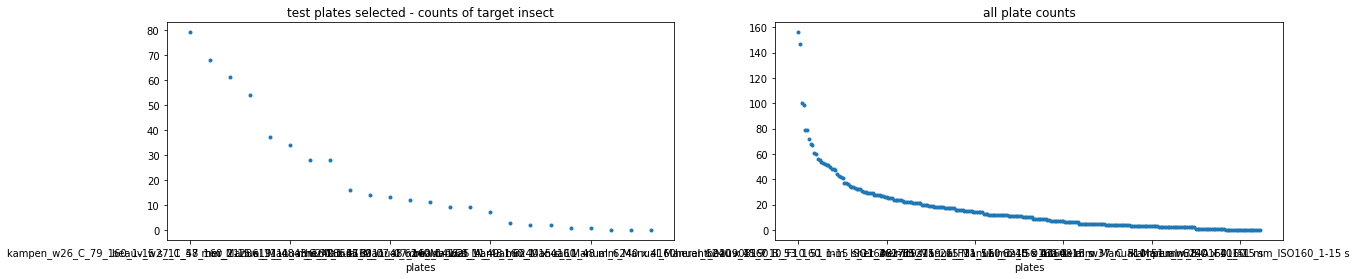

In [3]:
target_insect_dict = {}
for i, sub in df_orig.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)

test_plates = [
    #'beauv_8719_C_84_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'kampen_w26_C_79_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_10_F10_51 mm_ISO160_1-15 s',
              'kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_3daysold',
#               'kampen_w26_A_77_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'brainlal_w27_B_59_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
#               'beauv_8719_B_83_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_13_F10_51 mm_ISO160_1-15 s',
              'beauv_w27_C_57_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
#               'brainlal_w27_A_58_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'her_2856719_03_03_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_14_F10_51 mm_ISO160_1-15 s',
#               'brainelal_8719_C_82_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauvech_w37_B_F10_51 mm_ISO160_1-15 s',
#                'her_2128619_16_48_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w27_AA_68_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2128619_11_43_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauvech_w35_B_F10_51 mm_ISO160_1-15 s',
               'brainlal_15_7_B_62_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w35_A_F10_51 mm_ISO160_1-15 s',
               'beauv_w27_A_55_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2856719_07_07_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w25_A_74_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2128619_07_39_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w25_B_75_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w28_A_64_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauv_w25_A_49_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_512719_14_30_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w37_C_F10_51 mm_ISO160_1-15 s',
               'kampen_w39_B_F10_51 mm_ISO160_1-15 s'
              ]

plt.figure(figsize=(20,4))
plt.subplot(121)
ser.loc[test_plates].plot(style='.'); plt.xlabel('plates');plt.title('test plates selected - counts of target insect')
print(f"nr of test plates: {ser.loc[test_plates].shape[0]}")
plt.subplot(122)
ser.plot(style='.'); plt.xlabel('plates'); plt.title('all plate counts')
print(f"nr of all plates: {ser.shape[0]}")

X_test = df_orig.x[df_orig.pname.isin(test_plates)]
y_test = df_orig.y[df_orig.pname.isin(test_plates)]

X_test, y_test = shuffle(X_test, y_test, random_state=seed)

In [4]:
print("Test set class balance")
print(df_orig[df_orig.pname.isin(test_plates) ].y_text.value_counts())

X_train = df_orig.x[~df_orig.pname.isin(test_plates)]
y_train = df_orig.y[~df_orig.pname.isin(test_plates)]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

Test set class balance
m        613
v        563
wmv      489
v(cy)    430
t        292
c        233
Name: y_text, dtype: int64


In [5]:
# Splitting into train/val/test # Randomly
# X_train, X_test, y_train, y_test = train_test_split(df_orig.x, df_orig.y, test_size=0.2, random_state=seed, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

In [6]:
augment_trainset(X_train=X_train, y_train=y_train, 
                 aug_imgs_path=path_images_augmented,
                 img_dim=img_dim,
                 nb_batches= 200, 
                 batch_size=500)

 Reading image data and assigning labels...
Normalizing data by dividing by 255.
Creating an ImageDataGenerator.
Creating directories for each class.
Fitting data generator on data.
Expanding dataset by using generator's flow method on data/labels.
using batch_size of 500
Finished augmentation in 200 batches of 500


In [7]:
# Gathering info on augmented X_train data
df_aug = pd.DataFrame()
df_aug['x'] = pd.Series(glob.glob(f"{path_images_augmented}/*/*.jpg"))
df_aug['textlabels'] = df_aug['x'].apply(lambda x: x.split('/')[-2])
df_aug['y'] = le.fit_transform(df_aug.textlabels)

In [8]:
X_train_aug = df_aug.x.tolist()
y_train_aug = df_aug.y.tolist()

c = list(zip(X_train_aug, y_train_aug))
random.shuffle(c)
X_train_aug, y_train_aug = zip(*c)
X_train_aug = list(X_train_aug)
y_train_aug = list(y_train_aug)
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

In [9]:
log_dir = './insectrec/created_data/logs/'
top_weights_path = f'./insectrec/created_data/weights/model_{modelname}_{img_dim}.h5'

callbacks_list = [ModelCheckpoint(monitor =  monitor,
                                  filepath =  top_weights_path,
                                  save_best_only = False,
                                  save_weights_only = False,
                                  verbose = 1),
                  EarlyStopping(monitor =  monitor,
                                patience =  es_patience,
                                verbose = 1),
                  ReduceLROnPlateau(monitor =  monitor,
                                    factor = 0.1,
                                    patience =  rlr_patience,
                                    verbose = 1),
                # CSVLogger(filename =  logfile),
                  TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)]

## TRAINING FROM SCRATCH

In [ ]:
base_model = Xception(include_top=False, weights=None, 
                        input_shape=(img_dim,img_dim,3))
# EfficientNetB2
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# model.summary()

In [12]:
# from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# model.summary()

In [ ]:
import math
FH = model.fit_generator(train_generator(X_train_aug, y_train_aug, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
                         validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
                         steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))), 
                         validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))), 
                         epochs=epochs, 
                         verbose=1, 
                         callbacks=callbacks_list, 
                         shuffle=True)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3114 steps, validate for 59 steps
Epoch 1/100
2279/3114 [====================>.........] - ETA: 2:44 - loss: 1.0454 - accuracy: 0.6039

In [ ]:
def common(a,b): 
    c = [value for value in a if value in b] 
    return c

common(X_test, X_train)

In [ ]:
len(X_train)

## FINE TUNING

In [ ]:
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                          input_shape=(img_dim,img_dim,3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# predictions = Dense(6, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# #for i, layer in enumerate(base_model.layers):
# #   print(i, layer.name)

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # train the model on the new data for a few epochs
# import math
# FH = model.fit_generator(train_generator(X_train_aug, y_train, batch_size=batch_size, nb_classes=6, img_dim=img_dim),
#                          validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
#                          steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))),
#                          validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))),
#                          epochs=epochs, 
#                          verbose=1, 
#                          callbacks=callbacks_list)

In [ ]:
# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:425]:
#    layer.trainable = False
# for layer in model.layers[425:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# FH2 = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
#     validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
#     epochs=epochs, verbose=1, callbacks=callbacks_list)

## EXTRACTING FEATURES